In [1]:
import pandas as pd

In [2]:
base = "../data"

In [3]:
df = pd.read_csv(f"{base}/train_preprocessed.csv")
df.sample(3)

,comment_text,id,identity_hate,insult,obscene,set,severe_toxic,threat,toxic,toxicity
65873,chemists are lazy people and in generally will...,b0264f12fe63e077,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
113777,utc if one takes that attitude it never will...,606f0698bc72acce,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0
60953,about cheat code dangers yeah i know i saw it...,a33436639000948e,0.0,0.0,0.0,train,0.0,0.0,0.0,0.0


In [4]:
df.shape

(159571, 10)

In [5]:
df_ = pd.read_csv(f"{base}/test_preprocessed.csv")
df = pd.concat([df, df_])
df.shape

(312735, 10)

<Axes: >

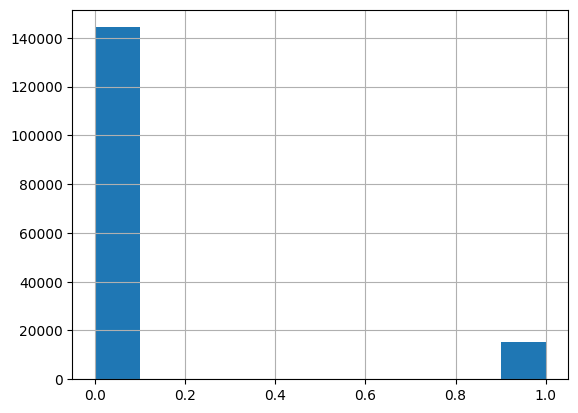

In [6]:
df.toxic.hist()

In [7]:
df2 = pd.read_csv(f"{base}/youtoxic_english_1000.csv")
df2.sample(3)

,CommentId,VideoId,Text,IsToxic,IsAbusive,IsThreat,IsProvocative,IsObscene,IsHatespeech,IsRacist,IsNationalist,IsSexist,IsHomophobic,IsReligiousHate,IsRadicalism
874,UghjQ3K_iYTc2XgCoAEC,#NAME?,For an inanimate object that police car was ve...,False,False,False,False,False,False,False,False,False,False,False,False
744,UggSA9NX_RN3VXgCoAEC,dG7mZQvaQDk,This is REAL black leadership. Real revolution...,False,False,False,False,False,False,False,False,False,False,False,False
13,UggMY2Oggks5LngCoAEC,04kJtp6pVXI,We all know with the chimpers there is no comp...,True,False,False,False,False,True,True,False,False,False,False,False


<Axes: >

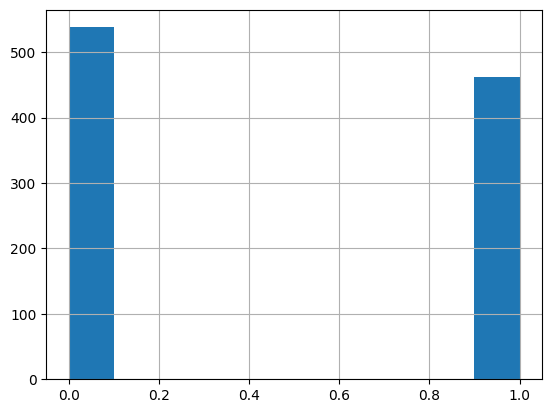

In [8]:
df2.IsToxic.apply(int).hist()

Будем заниматься бинарной классификацией для предсказанания целевой переменной isToxic. В качестве метрики используем *f1-score*